In [98]:
import numpy as np
import pandas as pd

In [101]:
df = pd.read_csv("../data/casino.csv")
true_x = np.array(df["x"])
y = np.array(df["y"])


Hidden Markov model:

\begin{align}
x_1 &\sim \mu(\cdot) \\
x_t | x_{t-1} &\sim p(\cdot|x_{t-1}) \\
y_t | x_t &\sim p(\cdot | x_t).
\end{align}

Filtering: compute $\alpha_t(j) = p(x_t = j | y_{1:t})$.

One-step prediction: $\alpha_{t|t-1}(j) = p(x_t = j | y_{1:t-1})$.

The recursion is given by,

\begin{align}
p(x_t | y_{1:t}) &= \frac{p(x_t, y_t | y_{1:t-1})}{p(y_t | y_{1:t-1})} \\
&= \frac{p(y_t | x_t) p(x_t | y_{1:t-1})}{p(y_t | y_{1:t-1})} \\
&= \frac{B_{x_t,y_t} \alpha_{t|t-1}(x_t)}{p(y_t | y_{1:t-1})}.
\end{align}

\begin{align}
    p(y_t | y_{1:t-1}) &= \sum_{x_t=0}^{1} p(y_t | x_t) p(x_t | y_{1:t-1}) \\
    &= \sum_{x_t=0}^{1} B_{x_t,y_t} \alpha_{t|t-1}(x_t).
\end{align}

Note: $\alpha_{t|t-1}(j) = \sum_{i=0}^{1} p(x_t = j, x_{t-1} = i | y_{1:t-1}) = \sum_{i=0}^{1} p(x_t = j | x_{t-1} = i) p(x_{t-1} = i | y_{1:t-1})$.

So, $\alpha_{t|t-1}(j) = \sum_{i} A_{ij} \alpha_{t-1}(i) = A^T \alpha_{t-1}$.

And therefore, in matrix form:

$$\alpha_t = \text{Normalize}(B_{y_t} \odot (A^T \alpha_{t-1})).$$

The algorithm has, 

1. prediction step where we compute $\alpha_{t|t-1}$;
2. update step where we compute $\alpha_t$;
3. marginalization step compute and save $m_t = p(y_t | y_{1:t-1})$.

Base case $t = 1$: compute

- $\alpha_{1|0}(j) = p(x_1 = j | \emptyset) = \mu(j)$;
- $\tilde{\alpha}_1(j) = B_{j,y_t} \alpha_{1|0}(j) = B_{j,y_t} \mu(j)$;
- $\alpha_1(j) = \tilde{\alpha}_1(j) / \sum_i \tilde{\alpha}_1(j)$.

For $t > 1$: compute

- $\alpha_{t|t-1} = p(x_t = j | y_{1:t-1}) = A^T \alpha_{t-1}$.
- $\alpha_t = \text{Normalize}(B \odot (A^T \alpha_{t-1}))$.


In [20]:
chain_length = y.shape[0]
K = 2
alpha = np.zeros((K, chain_length))
alpha_pred = np.zeros((K, chain_length))
marginals = np.zeros(chain_length)

In [103]:
# Generate some data.
mu = np.array([0.5, 0.5])
print(mu)
A = np.array([[0.9, 0.1], [0.2, 0.8]])
print(A)
fair_die = np.ones(6)/6.
loaded_die = np.ones(6)/10.
loaded_die[5] = 5/10.
B = np.row_stack((fair_die, loaded_die))
print(B)

[0.5 0.5]
[[0.9 0.1]
 [0.2 0.8]]
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]


In [115]:
alpha_pred[:,0] = mu
unnorm = B[:,y[0]-1] * alpha_pred[:,0]
alpha[:,0] = unnorm / unnorm.sum()
print(y[0])
alpha[:,0]

for t in range(1, chain_length):
    alpha_pred[:,t] = A.T @ alpha[:,t-1]
    unnorm = B[:,y[t]-1] * alpha_pred[:,t]
    alpha[:,t] = unnorm/unnorm.sum()



1


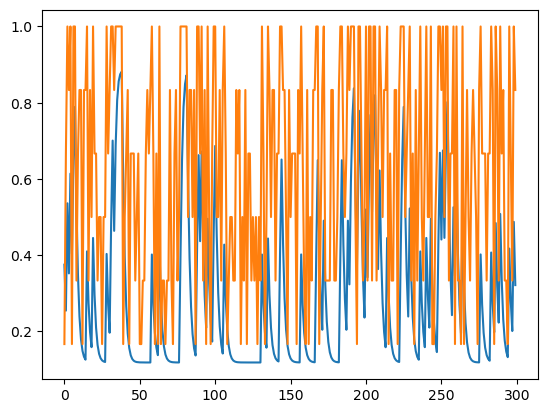

In [119]:
plt.plot(alpha[1,:])
plt.plot(y/6)

In [121]:
np.min(alpha)
alpha[1,48:50]

array([0.11946079, 0.11890715])

In [44]:
alpha_pred[:,0] = mu
alpha_unnorm = B[:,y[0]-1] * alpha_pred[:,0]
norm = alpha_unnorm.sum()
alpha[:,0] = alpha_unnorm/norm
marginals[0] = norm

In [45]:
for t in range(1, chain_length):
    alpha_pred[:,t] = A.T @ alpha[:,t-1]
    alpha_unnorm = B[:,y[t]-1] * alpha_pred[:,t]
    norm = alpha_unnorm.sum()
    alpha[:,t] = alpha_unnorm / norm
    marginals[t] = norm